# **DCGAN to generate Anime Avatars**

<a target="_blank" href="https://colab.research.google.com/github/moshiurtonmoy/Anime-Avatar-Generation-with-DCGAN/blob/master/DCGAN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

In [ ]:
# !nvidia-smi

### Load Data

In [ ]:
BASE_DIR = '../anime-faces/data'

In [ ]:
image_paths = [] # all image path list

for img_name in os.listdir(BASE_DIR):
    img_path = os.path.join(BASE_DIR, img_name)
    image_paths.append(img_path)
image_paths.remove('../anime-faces/data/data')

In [ ]:
train_images = [np.array(load_img(img)) for img in tqdm(image_paths)]

In [ ]:
train_images = np.array(train_images).astype('float32')
train_images.shape

(21551, 64, 64, 3)

In [ ]:
import cv2

## reshape the array to desired shape and normalized to [-1, 1] for TanH in Generator
# desired_shape = (64, 64)
# resized_images = []
# for image in train_images:
#     resized_image = cv2.resize(image, (desired_shape))
#     resized_images.append(resized_image)

# train_images = np.array(resized_images).astype('float32')
# train_images = np.array(train).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_images.shape

(21551, 64, 64, 3)

### Visualize Data

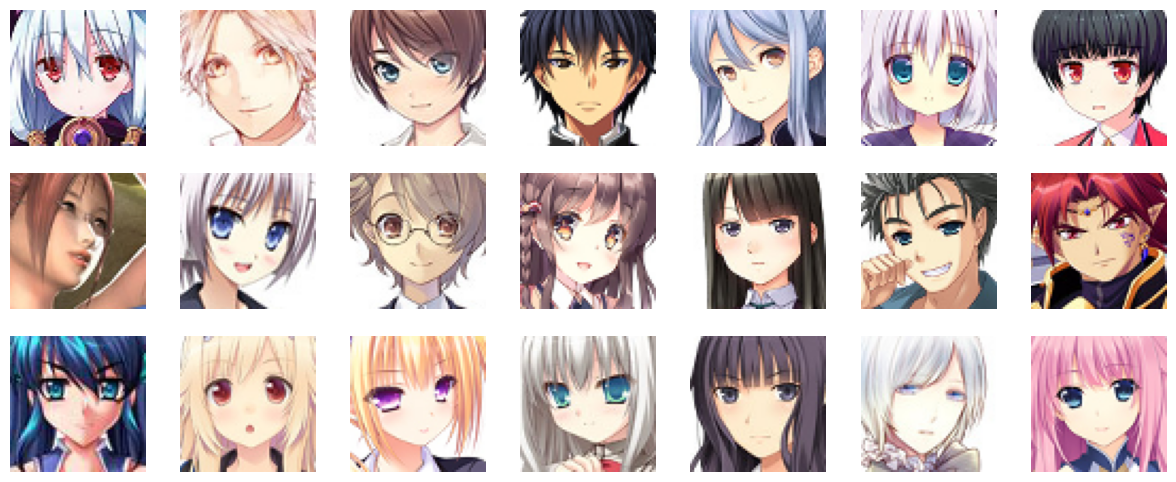

In [ ]:
plt.figure(figsize=(15,6))
selected_images = image_paths[:21]
idx = 1

for image in selected_images:
    plt.subplot(3, 7, idx)
    img = load_img(image)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')
    idx += 1


### Generator

In [ ]:
LATENT_DIM = 128
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0, stddev=0.02)
CHANNELS = 3 # rgb

In [ ]:
def generator():
    # 1D random noise
    inputs = layers.Input(shape=(LATENT_DIM,))
    x = layers.Dense(8 * 8 * 512)(inputs)

    # reshape to 3D
    x = layers.Reshape((8, 8, 512))(x)
#     x = layers.BatchNormalization()(x)

    # upsample to 16x16
    x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='selu', kernel_initializer=WEIGHT_INIT)(x)
    x = layers.BatchNormalization()(x)

    # upsample to 32x32
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='selu', kernel_initializer=WEIGHT_INIT)(x)
    x = layers.BatchNormalization()(x)

    # upsample to 64x64
    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='selu', kernel_initializer=WEIGHT_INIT)(x)
    x = layers.BatchNormalization()(x)

    # output
    output = layers.Conv2D(CHANNELS, kernel_size=4, padding='same', activation='tanh')(x)

    generator = Model(inputs=inputs, outputs=output, name='generator')
    return generator

In [ ]:
generator = generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 32768)             4227072   
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      52

### Discriminator

In [ ]:
INPUT_SHAPE = (64, 64)
alpha = 0.2

In [ ]:
def discriminator():
    # input 64x64x3
    inputs = layers.Input(shape=(*INPUT_SHAPE,3))

    # downsample to 32x32
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=alpha)(x)
#     x = layers.Dropout(0.2)(x)

    # downsample to 16x16
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=alpha)(x)
#     x = layers.Dropout(0.2)(x)

    # downsample to 8x8
    x = layers.Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=alpha)(x)
#     x = layers.Dropout(0.2)(x)

    # output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(1, activation='sigmoid')(x) # Classifying Fake or Real

    discriminator = Model(inputs=inputs, outputs=output, name='discriminator')
    return discriminator

In [ ]:
discriminator = discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       6272      
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       524544    
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 256)      1024      
 hNormalization)                                     

### DCGAN

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.gen_loss_metric = keras.metrics.Mean(name='generator_loss_metric')
        self.dis_loss_metric = keras.metrics.Mean(name='discriminator_loss_metric')

    @property
    def metrics(self):
        return [self.gen_loss_metric, self.dis_loss_metric]

    def compile(self, gen_optimizer, dis_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.gen_optimizer = gen_optimizer
        self.dis_optimizer = dis_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # generate random noise for batches
        batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the Discriminator with REAL and FAKE images
        with tf.GradientTape() as tape:
            # Loss on REAL images
            pred_real = self.discriminator(real_images, training=True)
            # generate REAL labels
            real_labels = tf.ones((batch_size, 1))
            real_labels = 0.05 * tf.random.uniform(tf.shape(real_labels)) # label smoothing
            dis_loss_real = self.loss_fn(real_labels, pred_real)

            # Loss on FAKE images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate FAKE labels
            fake_labels = tf.zeros((batch_size, 1))
            dis_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total Discriminator Loss
            dis_loss = (dis_loss_real + dis_loss_fake) / 2

        # compute and update the Discriminator gradients
        gradients = tape.gradient(dis_loss, self.discriminator.trainable_variables)
        self.dis_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        # train the Generator
        labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            # let's fool the Discriminator
            fake_images = self.generator(random_noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            gen_loss = self.loss_fn(labels, pred_fake)

        # compute and update the Discriminator gradients
        gradients = tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # update states for both models
        self.gen_loss_metric.update_state(gen_loss)
        self.dis_loss_metric.update_state(dis_loss)

        return {'generator_loss': self.gen_loss_metric.result(), 'discriminator_loss':self.dis_loss_metric.result()}

In [ ]:
class MonitorDCGAN(keras.callbacks.Callback):
    def __init__(self, num_imgs=16, latent_dim=LATENT_DIM):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        self.noise = tf.random.normal([num_imgs, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        if epoch==0 or epoch%20 == 0:
            gen_img = self.model.generator(self.noise) # generate new img from random_noise
            gen_img = (gen_img * 127.5) + 127.5 # denormalizing the generated img
            gen_img.numpy()

            fig = plt.figure(figsize=(6,6)) # displaying generated img samples after on each epoch
            for i in range(self.num_imgs):
                plt.subplot(4, 4, i+1)
                img = array_to_img(gen_img[i])
                plt.imshow(img)
                plt.axis('off')
            plt.show()

    def on_train_end(self, epoch, logs=None):
        self.model.generator.save('generator.h5')
        print("Generator saved!!")


### Training the DCGAN

In [ ]:
DIS_LR = 1e-4
GEN_LR = 3e-4 # gen_lr > dis_lr
NUM_EPOCH = 300

In [ ]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [ ]:
dcgan.compile(gen_optimizer=Adam(learning_rate=GEN_LR, beta_1=0.5), dis_optimizer=Adam(learning_rate=DIS_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

Epoch 1/300
674/674 [==============================] - ETA: 0s - generator_loss: 3.9065 - discriminator_loss: 0.1516

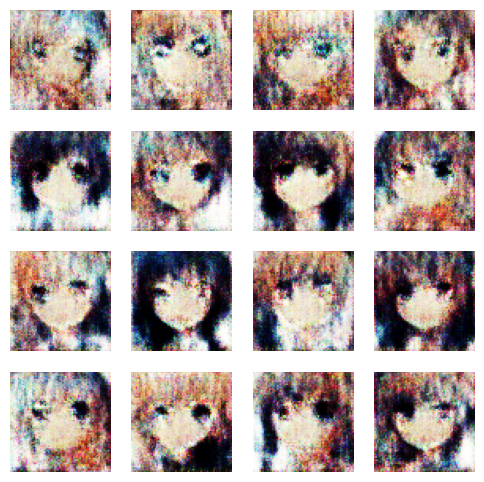

674/674 [==============================] - 56s 62ms/step - generator_loss: 3.9065 - discriminator_loss: 0.1515
Epoch 2/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 4.4125 - discriminator_loss: 0.0722
Epoch 3/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 4.4925 - discriminator_loss: 0.0705
Epoch 4/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 4.5826 - discriminator_loss: 0.0698
Epoch 5/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 4.5768 - discriminator_loss: 0.0700
Epoch 6/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 4.5845 - discriminator_loss: 0.0694
Epoch 7/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 4.5869 - discriminator_loss: 0.0692
Epoch 8/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 4.6285 - discriminator_loss: 0.0686
Epoch 9/300
674/674 [=======

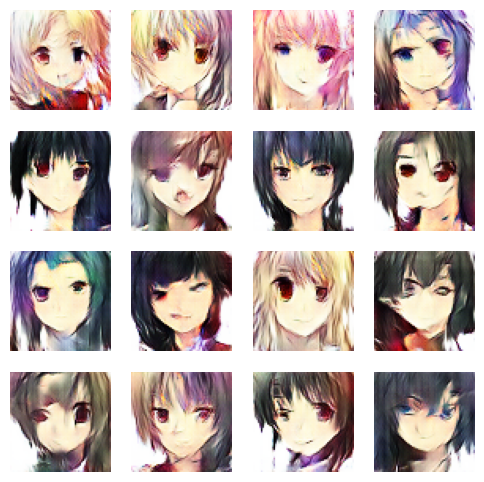

674/674 [==============================] - 41s 61ms/step - generator_loss: 4.7808 - discriminator_loss: 0.0674
Epoch 22/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 4.8165 - discriminator_loss: 0.0668
Epoch 23/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 4.7997 - discriminator_loss: 0.0672
Epoch 24/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 4.8066 - discriminator_loss: 0.0666
Epoch 25/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 4.8463 - discriminator_loss: 0.0669
Epoch 26/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 4.8261 - discriminator_loss: 0.0673
Epoch 27/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 4.8497 - discriminator_loss: 0.0666
Epoch 28/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 4.8619 - discriminator_loss: 0.0672
Epoch 29/300
674/674 

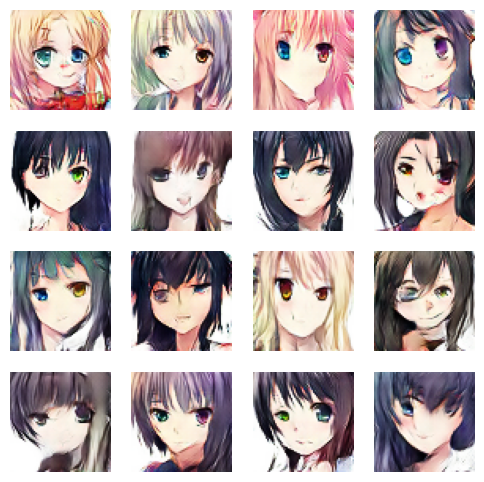

674/674 [==============================] - 41s 61ms/step - generator_loss: 5.0245 - discriminator_loss: 0.0661
Epoch 42/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.0329 - discriminator_loss: 0.0662
Epoch 43/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.0420 - discriminator_loss: 0.0661
Epoch 44/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.0304 - discriminator_loss: 0.0660
Epoch 45/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.0429 - discriminator_loss: 0.0659
Epoch 46/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.0579 - discriminator_loss: 0.0660
Epoch 47/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.0286 - discriminator_loss: 0.0669
Epoch 48/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.0607 - discriminator_loss: 0.0652
Epoch 49/300
674/674 

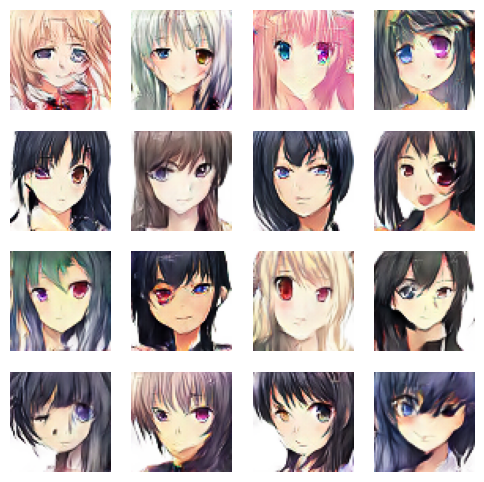

674/674 [==============================] - 41s 61ms/step - generator_loss: 5.2007 - discriminator_loss: 0.0651
Epoch 62/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.2040 - discriminator_loss: 0.0650
Epoch 63/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.2273 - discriminator_loss: 0.0644
Epoch 64/300
674/674 [==============================] - 41s 61ms/step - generator_loss: 5.2229 - discriminator_loss: 0.0649
Epoch 65/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.2376 - discriminator_loss: 0.0650
Epoch 66/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.2372 - discriminator_loss: 0.0650
Epoch 67/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.2183 - discriminator_loss: 0.0655
Epoch 68/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.2254 - discriminator_loss: 0.0648
Epoch 69/300
674/674 

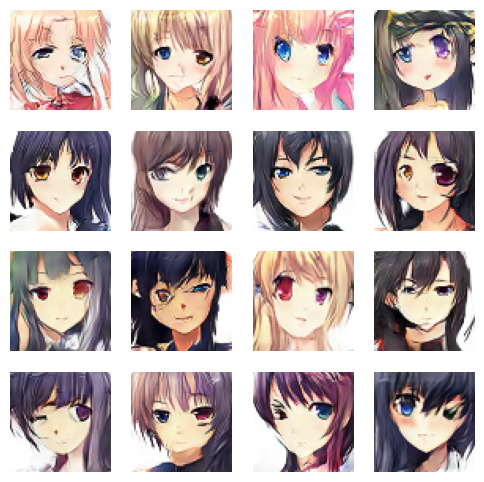

674/674 [==============================] - 41s 61ms/step - generator_loss: 5.3537 - discriminator_loss: 0.0644
Epoch 82/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.3471 - discriminator_loss: 0.0645
Epoch 83/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.3640 - discriminator_loss: 0.0645
Epoch 84/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.3624 - discriminator_loss: 0.0646
Epoch 85/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.4060 - discriminator_loss: 0.0643
Epoch 86/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.3892 - discriminator_loss: 0.0643
Epoch 87/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.3826 - discriminator_loss: 0.0645
Epoch 88/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.3829 - discriminator_loss: 0.0644
Epoch 89/300
674/674 

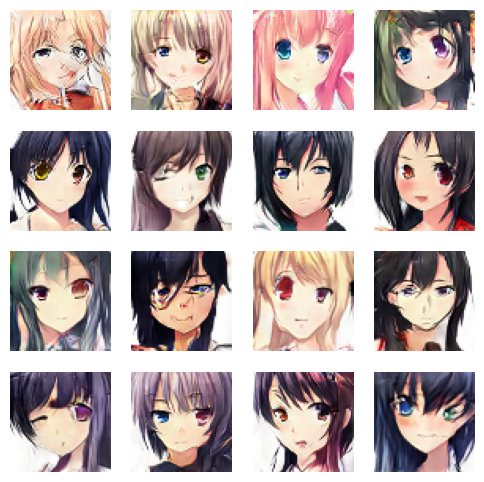

674/674 [==============================] - 41s 61ms/step - generator_loss: 5.4512 - discriminator_loss: 0.0640
Epoch 102/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.4588 - discriminator_loss: 0.0639
Epoch 103/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.4667 - discriminator_loss: 0.0642
Epoch 104/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.4575 - discriminator_loss: 0.0631
Epoch 105/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.4728 - discriminator_loss: 0.0641
Epoch 106/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.4809 - discriminator_loss: 0.0638
Epoch 107/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.4710 - discriminator_loss: 0.0640
Epoch 108/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.4930 - discriminator_loss: 0.0638
Epoch 109/300


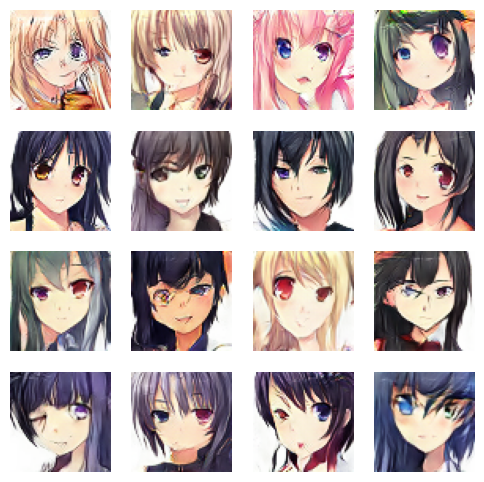

674/674 [==============================] - 41s 61ms/step - generator_loss: 5.5304 - discriminator_loss: 0.0640
Epoch 122/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.5442 - discriminator_loss: 0.0639
Epoch 123/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.5419 - discriminator_loss: 0.0636
Epoch 124/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.5536 - discriminator_loss: 0.0637
Epoch 125/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.5736 - discriminator_loss: 0.0634
Epoch 126/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.5682 - discriminator_loss: 0.0636
Epoch 127/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.5613 - discriminator_loss: 0.0633
Epoch 128/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.5612 - discriminator_loss: 0.0633
Epoch 129/300


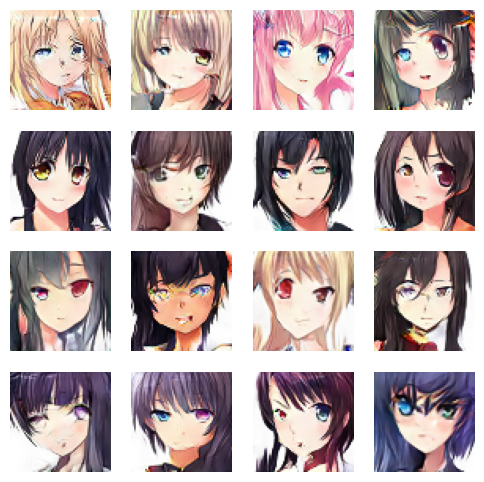

674/674 [==============================] - 41s 61ms/step - generator_loss: 5.6208 - discriminator_loss: 0.0628
Epoch 142/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.6373 - discriminator_loss: 0.0635
Epoch 143/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.6211 - discriminator_loss: 0.0631
Epoch 144/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.6209 - discriminator_loss: 0.0639
Epoch 145/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.6320 - discriminator_loss: 0.0629
Epoch 146/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.6484 - discriminator_loss: 0.0629
Epoch 147/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.6458 - discriminator_loss: 0.0633
Epoch 148/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.6486 - discriminator_loss: 0.0629
Epoch 149/300


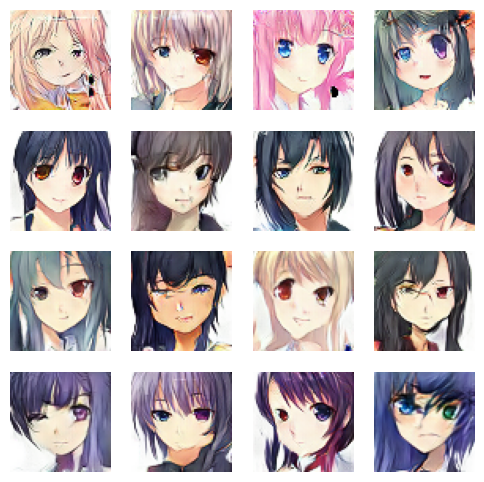

674/674 [==============================] - 41s 61ms/step - generator_loss: 5.6707 - discriminator_loss: 0.0636
Epoch 162/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.6604 - discriminator_loss: 0.0629
Epoch 163/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.6774 - discriminator_loss: 0.0630
Epoch 164/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.6983 - discriminator_loss: 0.0631
Epoch 165/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.6880 - discriminator_loss: 0.0630
Epoch 166/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.6812 - discriminator_loss: 0.0632
Epoch 167/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.6970 - discriminator_loss: 0.0627
Epoch 168/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.6865 - discriminator_loss: 0.0629
Epoch 169/300


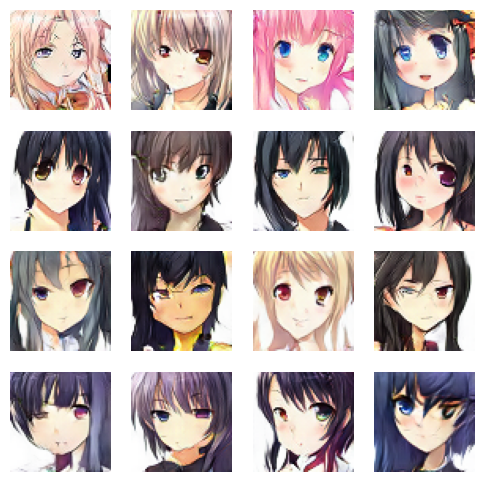

674/674 [==============================] - 41s 61ms/step - generator_loss: 5.7203 - discriminator_loss: 0.0632
Epoch 182/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.7352 - discriminator_loss: 0.0627
Epoch 183/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.7347 - discriminator_loss: 0.0627
Epoch 184/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.7255 - discriminator_loss: 0.0630
Epoch 185/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.7257 - discriminator_loss: 0.0634
Epoch 186/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.7537 - discriminator_loss: 0.0622
Epoch 187/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.7392 - discriminator_loss: 0.0629
Epoch 188/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.7430 - discriminator_loss: 0.0630
Epoch 189/300


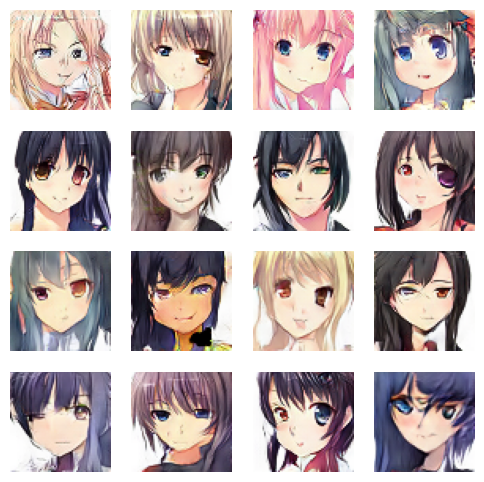

674/674 [==============================] - 41s 61ms/step - generator_loss: 5.7694 - discriminator_loss: 0.0623
Epoch 202/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.7737 - discriminator_loss: 0.0628
Epoch 203/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.8012 - discriminator_loss: 0.0627
Epoch 204/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.7762 - discriminator_loss: 0.0628
Epoch 205/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.7887 - discriminator_loss: 0.0628
Epoch 206/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.7855 - discriminator_loss: 0.0626
Epoch 207/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.7839 - discriminator_loss: 0.0629
Epoch 208/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.7895 - discriminator_loss: 0.0623
Epoch 209/300


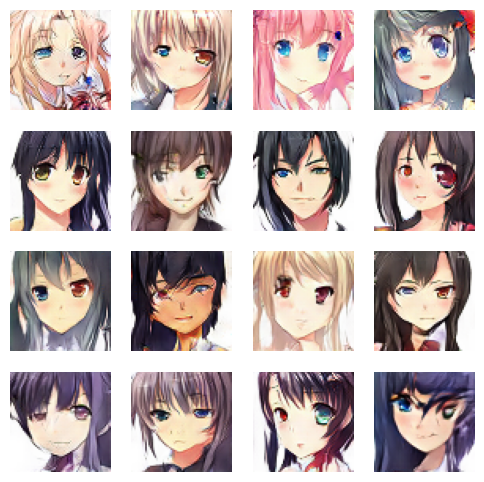

674/674 [==============================] - 41s 61ms/step - generator_loss: 5.8187 - discriminator_loss: 0.0624
Epoch 222/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.7948 - discriminator_loss: 0.0633
Epoch 223/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.8170 - discriminator_loss: 0.0628
Epoch 224/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.8386 - discriminator_loss: 0.0622
Epoch 225/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.8363 - discriminator_loss: 0.0623
Epoch 226/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.8233 - discriminator_loss: 0.0627
Epoch 227/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.8017 - discriminator_loss: 0.0634
Epoch 228/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.8292 - discriminator_loss: 0.0626
Epoch 229/300


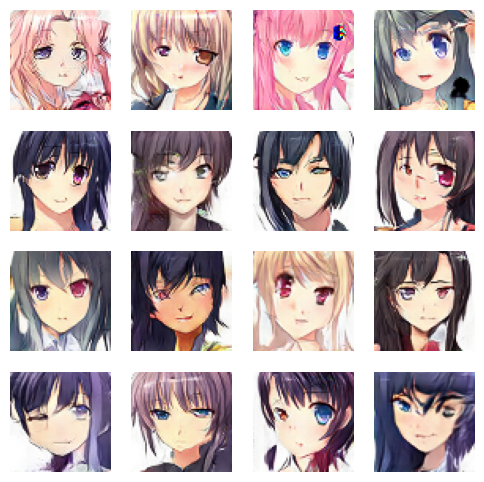

674/674 [==============================] - 41s 61ms/step - generator_loss: 5.8549 - discriminator_loss: 0.0626
Epoch 242/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.8446 - discriminator_loss: 0.0627
Epoch 243/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.8451 - discriminator_loss: 0.0623
Epoch 244/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.8557 - discriminator_loss: 0.0622
Epoch 245/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.8468 - discriminator_loss: 0.0631
Epoch 246/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.8476 - discriminator_loss: 0.0625
Epoch 247/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.8540 - discriminator_loss: 0.0621
Epoch 248/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.8469 - discriminator_loss: 0.0628
Epoch 249/300


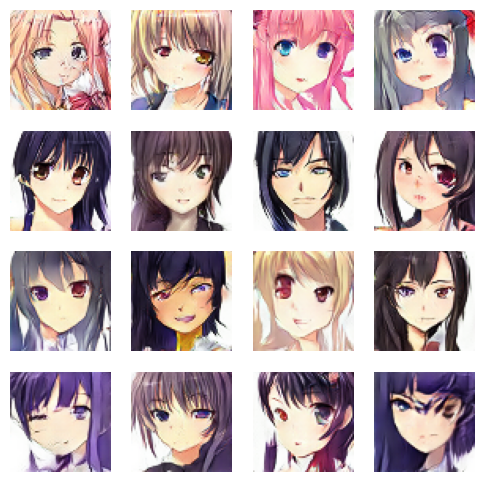

674/674 [==============================] - 41s 61ms/step - generator_loss: 5.8765 - discriminator_loss: 0.0629
Epoch 262/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.8866 - discriminator_loss: 0.0624
Epoch 263/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.8858 - discriminator_loss: 0.0623
Epoch 264/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.8984 - discriminator_loss: 0.0620
Epoch 265/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.8738 - discriminator_loss: 0.0625
Epoch 266/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.9079 - discriminator_loss: 0.0625
Epoch 267/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.8936 - discriminator_loss: 0.0621
Epoch 268/300
674/674 [==============================] - 41s 60ms/step - generator_loss: 5.9073 - discriminator_loss: 0.0625
Epoch 269/300


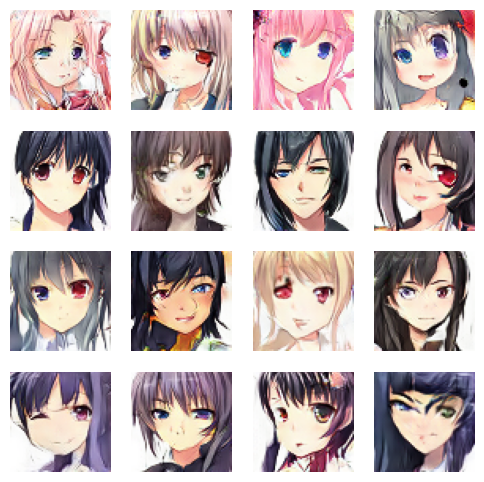

674/674 [==============================] - 40s 60ms/step - generator_loss: 5.9300 - discriminator_loss: 0.0621
Epoch 282/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.9085 - discriminator_loss: 0.0625
Epoch 283/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.9248 - discriminator_loss: 0.0624
Epoch 284/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.9074 - discriminator_loss: 0.0626
Epoch 285/300
674/674 [==============================] - 40s 60ms/step - generator_loss: 5.9374 - discriminator_loss: 0.0620
Epoch 286/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.9199 - discriminator_loss: 0.0626
Epoch 287/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.9300 - discriminator_loss: 0.0623
Epoch 288/300
674/674 [==============================] - 40s 59ms/step - generator_loss: 5.9287 - discriminator_loss: 0.0622
Epoch 289/300


In [ ]:
dcgan.fit(train_images, epochs=NUM_EPOCH, callbacks=[MonitorDCGAN()])